# 1. Introducción

En este notebook, vamos a calcular cromagramas a partir de archivos de audio, 
para su posterior uso en un sistema de reconocimiento de acordes basado en 
plantillas (*template-based chord recognition*).

Las funciones clave que usaremos son:

- `compute_chromagram_from_filename`: que nos permite calcular diferentes variantes de cromagramas (STFT, CQT o IIR) a partir de un archivo de audio.
- `normalize_feature_sequence`: para normalizar secuencias de características (en este caso, cromas).

Empecemos importando las librerías necesarias.


In [1]:
import os
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import librosa

# En caso de que tengamos librerías personalizadas en un directorio superior
import sys
sys.path.append('..')  # Ajustar según sea necesario

# (Opcional) Configurar estilo de gráficos
plt.style.use('ggplot')

# Definir una ruta a la carpeta de datos, en caso de ser útil
DATA_FOLDER = 'data'


## 2. Función: `normalize_feature_sequence`

Esta función nos permite normalizar columnas de una matriz de características 
(e.g. un cromagrama) según diversas normas: 
- norm='1': normaliza cada columna de forma que la suma absoluta de sus valores sea 1.
- norm='2': normaliza para que la norma euclidiana (L2) sea 1.
- norm='max': divide la columna por su máximo valor absoluto.
- norm='z': realiza una normalización tipo estandarización (z-score).

Este tipo de normalización ayuda a homogenizar la escala de las características 
para que luego su comparación (por ejemplo, el producto interno) sea más coherente.


In [2]:
def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    """
    Normalizes the columns of a feature sequence (matriz K x N, 
    donde K es la dimensión de la característica y N el número de frames).

    Parameters
    ----------
    X : np.ndarray
        Feature sequence (K x N).
    norm : str
        Tipo de norma a aplicar. Puede ser:
          - '1': norma L1 (suma de valores absolutos).
          - '2': norma L2 (euclidiana).
          - 'max': divide por el valor absoluto máximo en la columna.
          - 'z': estandarización (z-score).
        (Valor por defecto = '2')
    threshold : float
        Umbral para evitar divisiones por cero. Si la norma es menor que 
        este valor, se usa un vector 'v' en su lugar. (Default = 0.0001)
    v : np.ndarray or None
        Vector que se usará si la norma está por debajo de 'threshold'. 
        Si es None, usa un vector por defecto (por ejemplo de 1/K para L1, etc.).

    Returns
    -------
    X_norm : np.ndarray
        Matriz X normalizada de la misma forma y dimensión.

    Notes
    -----
    - Cada columna de X se normaliza de manera independiente.
    """
    assert norm in ['1', '2', 'max', 'z'], "Norm must be one of '1','2','max','z'"

    K, N = X.shape
    X_norm = np.zeros((K, N))

    # Normalización L1
    if norm == '1':
        if v is None:
            # Por defecto, vector de 1/K si la norma es muy pequeña
            v = np.ones(K, dtype=np.float64) / K
        for n in range(N):
            s = np.sum(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    # Normalización L2
    elif norm == '2':
        if v is None:
            # Por defecto, vector 1/sqrt(K) si la norma es muy pequeña
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in range(N):
            s = np.sqrt(np.sum(X[:, n] ** 2))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    # Normalización max
    elif norm == 'max':
        if v is None:
            # Por defecto, un vector de unos en caso extremo
            v = np.ones(K, dtype=np.float64)
        for n in range(N):
            s = np.max(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    # Normalización z-score
    elif norm == 'z':
        if v is None:
            # Por defecto, un vector de ceros si la varianza es muy baja
            v = np.zeros(K, dtype=np.float64)
        for n in range(N):
            mu = np.mean(X[:, n])
            sigma = np.std(X[:, n], ddof=1)  # ddof=1 para varianza muestral
            if sigma > threshold:
                X_norm[:, n] = (X[:, n] - mu) / sigma
            else:
                X_norm[:, n] = v

    return X_norm


Cada columna de la matriz X se procesa de forma independiente.

Distintos métodos de normalización pueden ser útiles dependiendo del tipo de comparación ulterior (por ejemplo, producto interno, distancia euclidiana, etc.).

## 3. Función: `compute_chromagram_from_filename`

Esta función lee un archivo de audio y computa un cromagrama de acuerdo a tres métodos:
- `'STFT'`: basándose en la transformada de Fourier a corto plazo. 
- `'CQT'`: usando la transformada de cosiente constante (*Constant-Q Transform*).
- `'IIR'`: aplicando primero filtros tipo IIR y luego extrayendo la energía asociada a cada banda de semitono.

También incluye:
- Un parámetro `gamma` para compresión logarítmica si se desea.
- Una normalización final controlada por `norm`.
- Devuelve el cromagrama `X`, la frecuencia de muestreo del cromagrama `Fs_X`,
  la señal de audio `x`, la frecuencia de muestreo `Fs` real, y la duración `x_dur`.

In [3]:
def compute_chromagram_from_filename(fn_wav, Fs=22050, N=4096, H=2048, gamma=None, version='STFT', norm='2'):
    """
    Compute a chromagram for a given WAV file.

    Parameters
    ----------
    fn_wav : str
        Filename (ruta) del archivo de audio .wav
    Fs : int
        Frecuencia de muestreo para cargar el audio (por defecto 22050).
    N : int
        Tamaño de ventana para STFT/IIR (por defecto 4096).
    H : int
        Hop size: número de samples que se avanza entre ventanas (por defecto 2048).
    gamma : float or None
        Constante de compresión logarítmica. Si es None, no se aplica compresión.
    version : str
        El tipo de cálculo de cromagrama ('STFT', 'CQT' o 'IIR'). Por defecto 'STFT'.
    norm : str
        Tipo de normalización de vectores de cromas ('1','2','max', None). Por defecto '2'.

    Returns
    -------
    X : np.ndarray
        Matriz de cromas de dimensión (12, num_frames).
    Fs_X : float
        Tasa de frames (características) resultante. Aproximadamente Fs/H.
    x : np.ndarray
        Señal de audio cargada.
    Fs : int
        Frecuencia de muestreo real del audio tras la carga.
    x_dur : float
        Duración en segundos de la señal 'x'.
    
    Notes
    -----
    - Si 'version'='STFT', se usa `librosa.feature.chroma_stft`.
    - Si 'version'='CQT', se usa `librosa.feature.chroma_cqt`.
    - Si 'version'='IIR', se aplica `librosa.iirt` y luego `chroma_cqt`.
    - Si 'gamma' no es None en 'STFT', se aplica compresión logaritmica. 
      Similar para 'IIR'.
    - Se aplica normalización final de las columnas con la función 
      'normalize_feature_sequence' si 'norm' no es None.
    """
    # 1. Cargar audio con librosa
    x, Fs = librosa.load(fn_wav, sr=Fs)
    x_dur = x.shape[0] / Fs

    # 2. Dependiendo de la opción 'version', calcular cromas
    if version == 'STFT':
        # STFT
        X_stft = librosa.stft(x, n_fft=N, hop_length=H, pad_mode='constant', center=True)
        if gamma is not None:
            # Aplicar compresión log(1 + gamma * |X|^2)
            X_pow = np.abs(X_stft) ** 2
            X_compressed = np.log(1 + gamma * X_pow)
            X = librosa.feature.chroma_stft(S=X_compressed, sr=Fs, tuning=0, 
                                            norm=None, hop_length=H, n_fft=N)
        else:
            # Sin compresión
            X_pow = np.abs(X_stft) ** 2
            X = librosa.feature.chroma_stft(S=X_pow, sr=Fs, tuning=0, 
                                            norm=None, hop_length=H, n_fft=N)

    elif version == 'CQT':
        # CQT
        X = librosa.feature.chroma_cqt(y=x, sr=Fs, hop_length=H, norm=None)

    elif version == 'IIR':
        # Filtro IIR elíptico
        X_iir = librosa.iirt(y=x, sr=Fs, win_length=N, hop_length=H, 
                             center=True, tuning=0.0)
        if gamma is not None:
            X_iir = np.log(1.0 + gamma * X_iir)
        X = librosa.feature.chroma_cqt(C=X_iir, bins_per_octave=12, n_octaves=7,
                                       fmin=librosa.midi_to_hz(24), norm=None)

    else:
        raise ValueError("version must be 'STFT','CQT' or 'IIR'")

    # 3. Normalización final de los cromas
    if norm is not None:
        X = normalize_feature_sequence(X, norm=norm)

    # 4. Tasa de frames (si hop_length = H, la nueva Fs_X ~ Fs/H)
    Fs_X = Fs / H

    return X, Fs_X, x, Fs, x_dur


## 4. Ejemplo de uso con un archivo

Ahora vamos a probar nuestra función `compute_chromagram_from_filename` 
con un archivo WAV concreto, y mostraremos la forma de la señal y el 
cromagrama resultante.


Cromagrama shape: (12, 276)
Tasa de frames cromáticos (Fs_X): 10.7666015625
Duración audio en segundos: 25.62172335600907


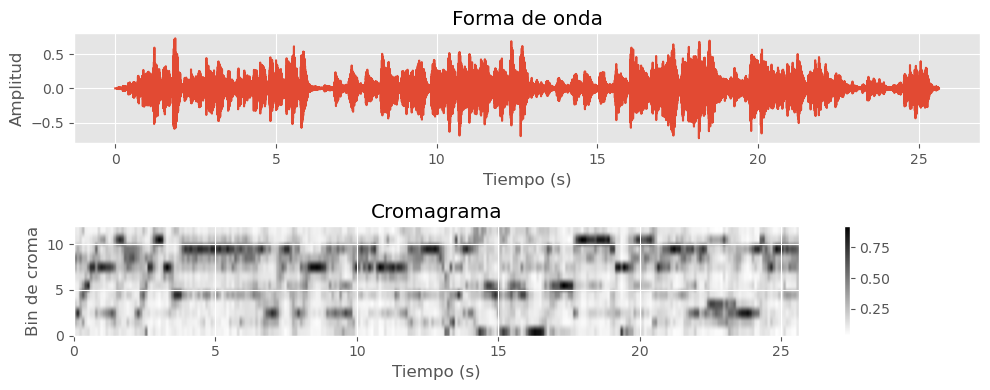

In [4]:
# Ejemplo: computar y graficar un cromagrama
example_audio = os.path.join('/home/cepatinog/ethnomusic/amplab-musicology-andina/if_0172.wav') 

X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(
    example_audio, 
    Fs=22050, 
    N=4096, 
    H=2048, 
    gamma=0.1, 
    version='CQT', 
    norm='2'
)

print("Cromagrama shape:", X.shape)
print("Tasa de frames cromáticos (Fs_X):", Fs_X)
print("Duración audio en segundos:", x_dur)

# Graficar la forma de onda y el cromagrama
plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
plt.plot(np.linspace(0, x_dur, len(x)), x)
plt.title('Forma de onda')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

plt.subplot(2,1,2)
plt.imshow(X, origin='lower', aspect='auto', cmap='gray_r',
           extent=[0, x_dur, 0, 12])
plt.title('Cromagrama')
plt.xlabel('Tiempo (s)')
plt.ylabel('Bin de croma')
plt.colorbar()
plt.tight_layout()
plt.show()


# Generación de Plantillas de Acordes Actualizadas

Esta función `generate_chord_templates` genera plantillas binarias para múltiples tipos de acordes. Cada plantilla se representa como un vector binario de dimensión 12, en el que cada posición (del 0 al 11) corresponde a una nota del sistema temperado (C, C#, D, …, B).

Los acordes incluidos son:
- 12 acordes mayores (triadas mayores)
- 12 acordes menores (triadas menores)
- 12 acordes dominantes séptima (C7, etc.)
- 12 acordes mayor séptima (Cmaj7, etc.)
- 12 acordes menor séptima (Cm7, etc.)
- 12 acordes disminuidos (half-diminished o m7b5: C, Eb, Gb, Bb)
- 12 acordes con sexta mayor (C6: C, E, G, A)
- 12 acordes con sexta menor (Cm6: C, Eb, G, A)

En total se generan 12 × 8 = 96 plantillas. Si se activa la opción `nonchord=True`, se añade una columna extra para representar frames sin acorde (por ejemplo, una columna de ceros).

Cada plantilla se construye a partir de un patrón base definido para la raíz C, y luego se desplaza cíclicamente (mediante `np.roll()`) para obtener la variación correspondiente a cada tono.

A continuación se muestra el código completo.


In [5]:
def generate_chord_templates(nonchord=False):
    """
    Generate chord templates for:
      - 12 major triads
      - 12 minor triads
      - 12 dominant seventh chords (7)
      - 12 major seventh chords (maj7)
      - 12 minor seventh chords (m7)
      - 12 half-diminished chords (m7b5)
      - 12 major sixth chords (6)
      - 12 minor sixth chords (m6)
      - (Optional) one nonchord template (if nonchord=True)

    Each chord template is a 12-dimensional binary vector indicating which pitch classes (0 to 11) are present in the chord.

    Base templates (for root C) are defined as follows:
      - C major triad:       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]    (C, E, G)
      - C minor triad:       [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]    (C, Eb, G)
      - C dominant 7:        [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]    (C, E, G, Bb)
      - C major 7:           [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]    (C, E, G, B)
      - C minor 7:           [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]    (C, Eb, G, Bb)
      - C half-diminished:   [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]    (C, Eb, Gb, Bb)
      - C6 (major 6):        [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]    (C, E, G, A)
      - Cmin6 (minor 6):     [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]    (C, Eb, G, A)

    For each chord type, the template is cyclically shifted to obtain all 12 variants.
    The final output is a matrix of shape (12, 96) if nonchord=False, or (12, 97) if nonchord=True.
    
    Returns:
        chord_templates (np.ndarray):
            Matrix containing all chord templates as columns.
    """
    # --- 1) Define base (C-root) templates for triads ---
    template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])
    template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])
    
    # --- 2) Define base templates for seventh chords ---
    template_c7    = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0])
    template_cmaj7 = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1])
    template_cm7   = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0])
    
    # --- 3) Define base template for half-diminished chords (m7b5) ---
    # C half-diminished: C, Eb, Gb, Bb -> intervals at 0, 3, 6, 10.
    template_cm7b5 = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0])
    
    # --- 4) Define base templates for chords with sixth ---
    # C6 (major 6): C, E, G, A -> intervals at 0, 4, 7, 9.
    template_c6 = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0])
    # Cmin6 (minor 6): C, Eb, G, A -> intervals at 0, 3, 7, 9.
    template_cm6 = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0])
    
    # --- 5) Preparar matrices para cada grupo (cada una con 12 columnas) ---
    chord_templates_maj    = np.zeros((12, 12))
    chord_templates_min    = np.zeros((12, 12))
    chord_templates_dom7   = np.zeros((12, 12))
    chord_templates_maj7   = np.zeros((12, 12))
    chord_templates_min7   = np.zeros((12, 12))
    chord_templates_halfdim = np.zeros((12, 12))
    chord_templates_6      = np.zeros((12, 12))
    chord_templates_min6   = np.zeros((12, 12))
    
    # --- 6) Rellenar cada matriz con el desplazamiento cíclico ---
    for shift in range(12):
        chord_templates_maj[:, shift]    = np.roll(template_cmaj, shift)
        chord_templates_min[:, shift]    = np.roll(template_cmin, shift)
        chord_templates_dom7[:, shift]   = np.roll(template_c7, shift)
        chord_templates_maj7[:, shift]   = np.roll(template_cmaj7, shift)
        chord_templates_min7[:, shift]   = np.roll(template_cm7, shift)
        chord_templates_halfdim[:, shift] = np.roll(template_cm7b5, shift)
        chord_templates_6[:, shift]      = np.roll(template_c6, shift)
        chord_templates_min6[:, shift]   = np.roll(template_cm6, shift)
        
    # --- 7) Agrupar horizontalmente todas las matrices ---
    # Se suman:
    # 12 (maj) + 12 (min) + 12 (dom7) + 12 (maj7) + 12 (min7) + 12 (half-dim) + 12 (6) + 12 (min6) = 96 columnas
    chord_templates = np.hstack([
        chord_templates_maj,
        chord_templates_min,
        chord_templates_dom7,
        chord_templates_maj7,
        chord_templates_min7,
        chord_templates_halfdim,
        chord_templates_6,
        chord_templates_min6
    ])
    
    # --- 8) Opcionalmente agregar una columna "nonchord" ---
    if nonchord:
        nonchord_col = np.zeros((12, 1))
        chord_templates = np.hstack([chord_templates, nonchord_col])
    
    return chord_templates


In [6]:
def chord_recognition_template(X, norm_sim='1', nonchord=False):
    """Conducts template-based chord recognition
    with major and minor triads (and possibly nonchord)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        X (np.ndarray): Chromagram
        norm_sim (str): Specifies norm used for normalizing chord similarity matrix (Default value = '1')
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_sim (np.ndarray): Chord similarity matrix
        chord_max (np.ndarray): Binarized chord similarity matrix only containing maximizing chord
    """
    chord_templates = generate_chord_templates(nonchord=nonchord)
    X_norm = normalize_feature_sequence(X, norm='2')
    chord_templates_norm = normalize_feature_sequence(chord_templates, norm='2')
    chord_sim = np.matmul(chord_templates_norm.T, X_norm)
    if norm_sim is not None:
        chord_sim =     normalize_feature_sequence(chord_sim, norm=norm_sim)
    # chord_max = (chord_sim == chord_sim.max(axis=0)).astype(int)
    chord_max_index = np.argmax(chord_sim, axis=0)
    chord_max = np.zeros(chord_sim.shape).astype(np.int32)
    for n in range(chord_sim.shape[1]):
        chord_max[chord_max_index[n], n] = 1

    return chord_sim, chord_max

# Generación de Etiquetas de Acordes

La función `get_chord_labels` genera una lista con los nombres de los acordes correspondientes a cada plantilla.
En esta versión actualizada se incluyen:
- 12 triadas mayores (e.g., C, C#, D, …)
- 12 triadas menores (e.g., Cm, C#m, Dm, …)
- 12 acordes dominantes 7 (e.g., C7, C#7, D7, …)
- 12 acordes mayor 7 (e.g., Cmaj7, C#maj7, Dmaj7, …)
- 12 acordes menor 7 (e.g., Cm7, C#m7, Dm7, …)
- 12 acordes medio-disminuidos (m7b5) (e.g., Cm7b5, C#m7b5, Dm7b5, …)
- 12 acordes con sexta (6) (e.g., C6, C#6, D6, …)
- 12 acordes con sexta menor (m6) (e.g., Cm6, C#m6, Dm6, …)

Opcionalmente, se puede añadir una etiqueta 'N' para representar frames sin acorde.


In [7]:
def get_chord_labels(ext_minor='m', 
                     ext_seventh='7', 
                     ext_major7='maj7', 
                     ext_min7='m7', 
                     ext_halfdim='m7b5', 
                     ext_sixth='6', 
                     ext_minsix='m6',
                     nonchord=False):
    """
    Generates a list of chord labels corresponding to the chord templates generated.
    
    The labels are generated in the following order (each group has 12 labels):
      1. Major triads:             C, C#, D, D#, E, F, F#, G, G#, A, A#, B
      2. Minor triads:             Cm, C#m, Dm, D#m, Em, Fm, F#m, Gm, G#m, Am, A#m, Bm
      3. Dominant 7 chords:         C7, C#7, D7, D#7, E7, F7, F#7, G7, G#7, A7, A#7, B7
      4. Major 7 chords:            Cmaj7, C#maj7, Dmaj7, D#maj7, Emaj7, Fmaj7, F#maj7, Gmaj7, G#maj7, Amaj7, A#maj7, Bmaj7
      5. Minor 7 chords:            Cm7, C#m7, Dm7, D#m7, Em7, Fm7, F#m7, Gm7, G#m7, Am7, A#m7, Bm7
      6. Half-diminished chords:    Cm7b5, C#m7b5, Dm7b5, D#m7b5, Em7b5, Fm7b5, F#m7b5, Gm7b5, G#m7b5, Am7b5, A#m7b5, Bm7b5
      7. Major 6 chords:            C6, C#6, D6, D#6, E6, F6, F#6, G6, G#6, A6, A#6, B6
      8. Minor 6 chords:            Cm6, C#m6, Dm6, D#m6, Em6, Fm6, F#m6, Gm6, G#m6, Am6, A#m6, Bm6
      
    If nonchord is True, an additional label 'N' is appended.
    
    Returns:
        chord_labels (list): List of chord labels (length 96 or 97 if nonchord=True).
    """
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    labels = []
    
    # 1. Major triads:
    for s in chroma_labels:
        labels.append(s)
    
    # 2. Minor triads:
    for s in chroma_labels:
        labels.append(s + ext_minor)
        
    # 3. Dominant 7 chords:
    for s in chroma_labels:
        labels.append(s + ext_seventh)
        
    # 4. Major 7 chords:
    for s in chroma_labels:
        labels.append(s + ext_major7)
        
    # 5. Minor 7 chords:
    for s in chroma_labels:
        labels.append(s + ext_min7)
        
    # 6. Half-diminished chords:
    for s in chroma_labels:
        labels.append(s + ext_halfdim)
        
    # 7. Major 6 chords:
    for s in chroma_labels:
        labels.append(s + ext_sixth)
        
    # 8. Minor 6 chords:
    for s in chroma_labels:
        labels.append(s + ext_minsix)
        
    if nonchord:
        labels.append('N')
        
    return labels


# Reconocimiento de Acordes y Visualización

En este bloque se realiza el reconocimiento de acordes usando el enfoque template-based. Se invoca la función 
`chord_recognition_template(X, norm_sim='max')` sobre el cromagrama X previamente computado. Esto produce:
  - `chord_sim`: una matriz de similitud en la que cada entrada representa la similitud (producto interno normalizado) 
    entre la plantilla de cada acorde y el vector cromático de un frame.
  - `chord_max`: una matriz binaria que indica, en cada frame, cuál fue el acorde seleccionado (la posición con la máxima similitud).

Posteriormente, se generan las etiquetas extendidas de acorde mediante la función 
`get_chord_labels()` que genera 96 etiquetas correspondientes a los 8 tipos de acordes, 12 para cada uno.

Para visualizar los resultados se realiza lo siguiente:
- En la parte superior se traza el cromagrama (usando `libfmp.b.plot_chromagram`) con los ejes y el mapa de colores, 
  lo cual permite observar la energía en cada banda de croma a lo largo del tiempo.
- En la parte inferior se muestra la representación tiempo–acorde del resultado del reconocimiento (matriz binaria `chord_max`), 
  en la que se establecen las etiquetas generadas en el eje y para poder identificar visualmente qué acorde fue asignado en cada momento.

Esta visualización es muy útil para comprobar intuitivamente la coincidencia entre el contenido tonal del audio (capturado en el cromagrama) 
y el acorde que se ha asignado frame a frame.

A continuación se presenta el código:


In [9]:
def plot_matrix(X, Fs=1, Fs_F=1, T_coef=None, F_coef=None, xlabel='Time (seconds)', ylabel='Frequency (Hz)',
                xlim=None, ylim=None, clim=None, title='', dpi=72,
                colorbar=True, colorbar_aspect=20.0, cbar_label='', ax=None, figsize=(6, 3), **kwargs):
    """2D raster visualization of a matrix, e.g. a spectrogram or a tempogram.

    Args:
        X: The matrix
        Fs: Sample rate for axis 1 (Default value = 1)
        Fs_F: Sample rate for axis 0 (Default value = 1)
        T_coef: Time coeffients. If None, will be computed, based on Fs. (Default value = None)
        F_coef: Frequency coeffients. If None, will be computed, based on Fs_F. (Default value = None)
        xlabel: Label for x-axis (Default value = 'Time (seconds)')
        ylabel: Label for y-axis (Default value = 'Frequency (Hz)')
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        clim: Color limits (Default value = None)
        title: Title for plot (Default value = '')
        dpi: Dots per inch (Default value = 72)
        colorbar: Create a colorbar. (Default value = True)
        colorbar_aspect: Aspect used for colorbar, in case only a single axes is used. (Default value = 20.0)
        cbar_label: Label for colorbar (Default value = '')
        ax: Either (1.) a list of two axes (first used for matrix, second for colorbar), or (2.) a list with a single
            axes (used for matrix), or (3.) None (an axes will be created). (Default value = None)
        figsize: Width, height in inches (Default value = (6, 3))
        **kwargs: Keyword arguments for matplotlib.pyplot.imshow

    Returns:
        fig: The created matplotlib figure or None if ax was given.
        ax: The used axes.
        im: The image plot
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        ax = [ax]
    if T_coef is None:
        T_coef = np.arange(X.shape[1]) / Fs
    if F_coef is None:
        F_coef = np.arange(X.shape[0]) / Fs_F

    if 'extent' not in kwargs:
        x_ext1 = (T_coef[1] - T_coef[0]) / 2
        x_ext2 = (T_coef[-1] - T_coef[-2]) / 2
        y_ext1 = (F_coef[1] - F_coef[0]) / 2
        y_ext2 = (F_coef[-1] - F_coef[-2]) / 2
        kwargs['extent'] = [T_coef[0] - x_ext1, T_coef[-1] + x_ext2, F_coef[0] - y_ext1, F_coef[-1] + y_ext2]
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray_r'
    if 'aspect' not in kwargs:
        kwargs['aspect'] = 'auto'
    if 'origin' not in kwargs:
        kwargs['origin'] = 'lower'
    if 'interpolation' not in kwargs:
        kwargs['interpolation'] = 'nearest'

    im = ax[0].imshow(X, **kwargs)

    if len(ax) == 2 and colorbar:
        cbar = plt.colorbar(im, cax=ax[1])
        cbar.set_label(cbar_label)
    elif len(ax) == 2 and not colorbar:
        ax[1].set_axis_off()
    elif len(ax) == 1 and colorbar:
        plt.sca(ax[0])
        cbar = plt.colorbar(im, aspect=colorbar_aspect)
        cbar.set_label(cbar_label)

    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)
    if xlim is not None:
        ax[0].set_xlim(xlim)
    if ylim is not None:
        ax[0].set_ylim(ylim)
    if clim is not None:
        im.set_clim(clim)

    if fig is not None:
        plt.tight_layout()

    return fig, ax, im

def plot_chromagram(*args, chroma_yticks=np.arange(12), **kwargs):
    """Call libfmp.b.plot_matrix and sets chroma labels.

    See :func:`libfmp.b.b_plot.plot_matrix` for parameters and return values.
    """
    if 'ylabel' not in kwargs:
        kwargs['ylabel'] = 'Chroma'
    fig, ax, im = plot_matrix(*args, **kwargs)

    chroma_names = 'C C# D D# E F F# G G# A A# B'.split()
    ax[0].set_yticks(np.array(chroma_yticks))
    ax[0].set_yticklabels([chroma_names[i] for i in chroma_yticks])

    return fig, ax, im

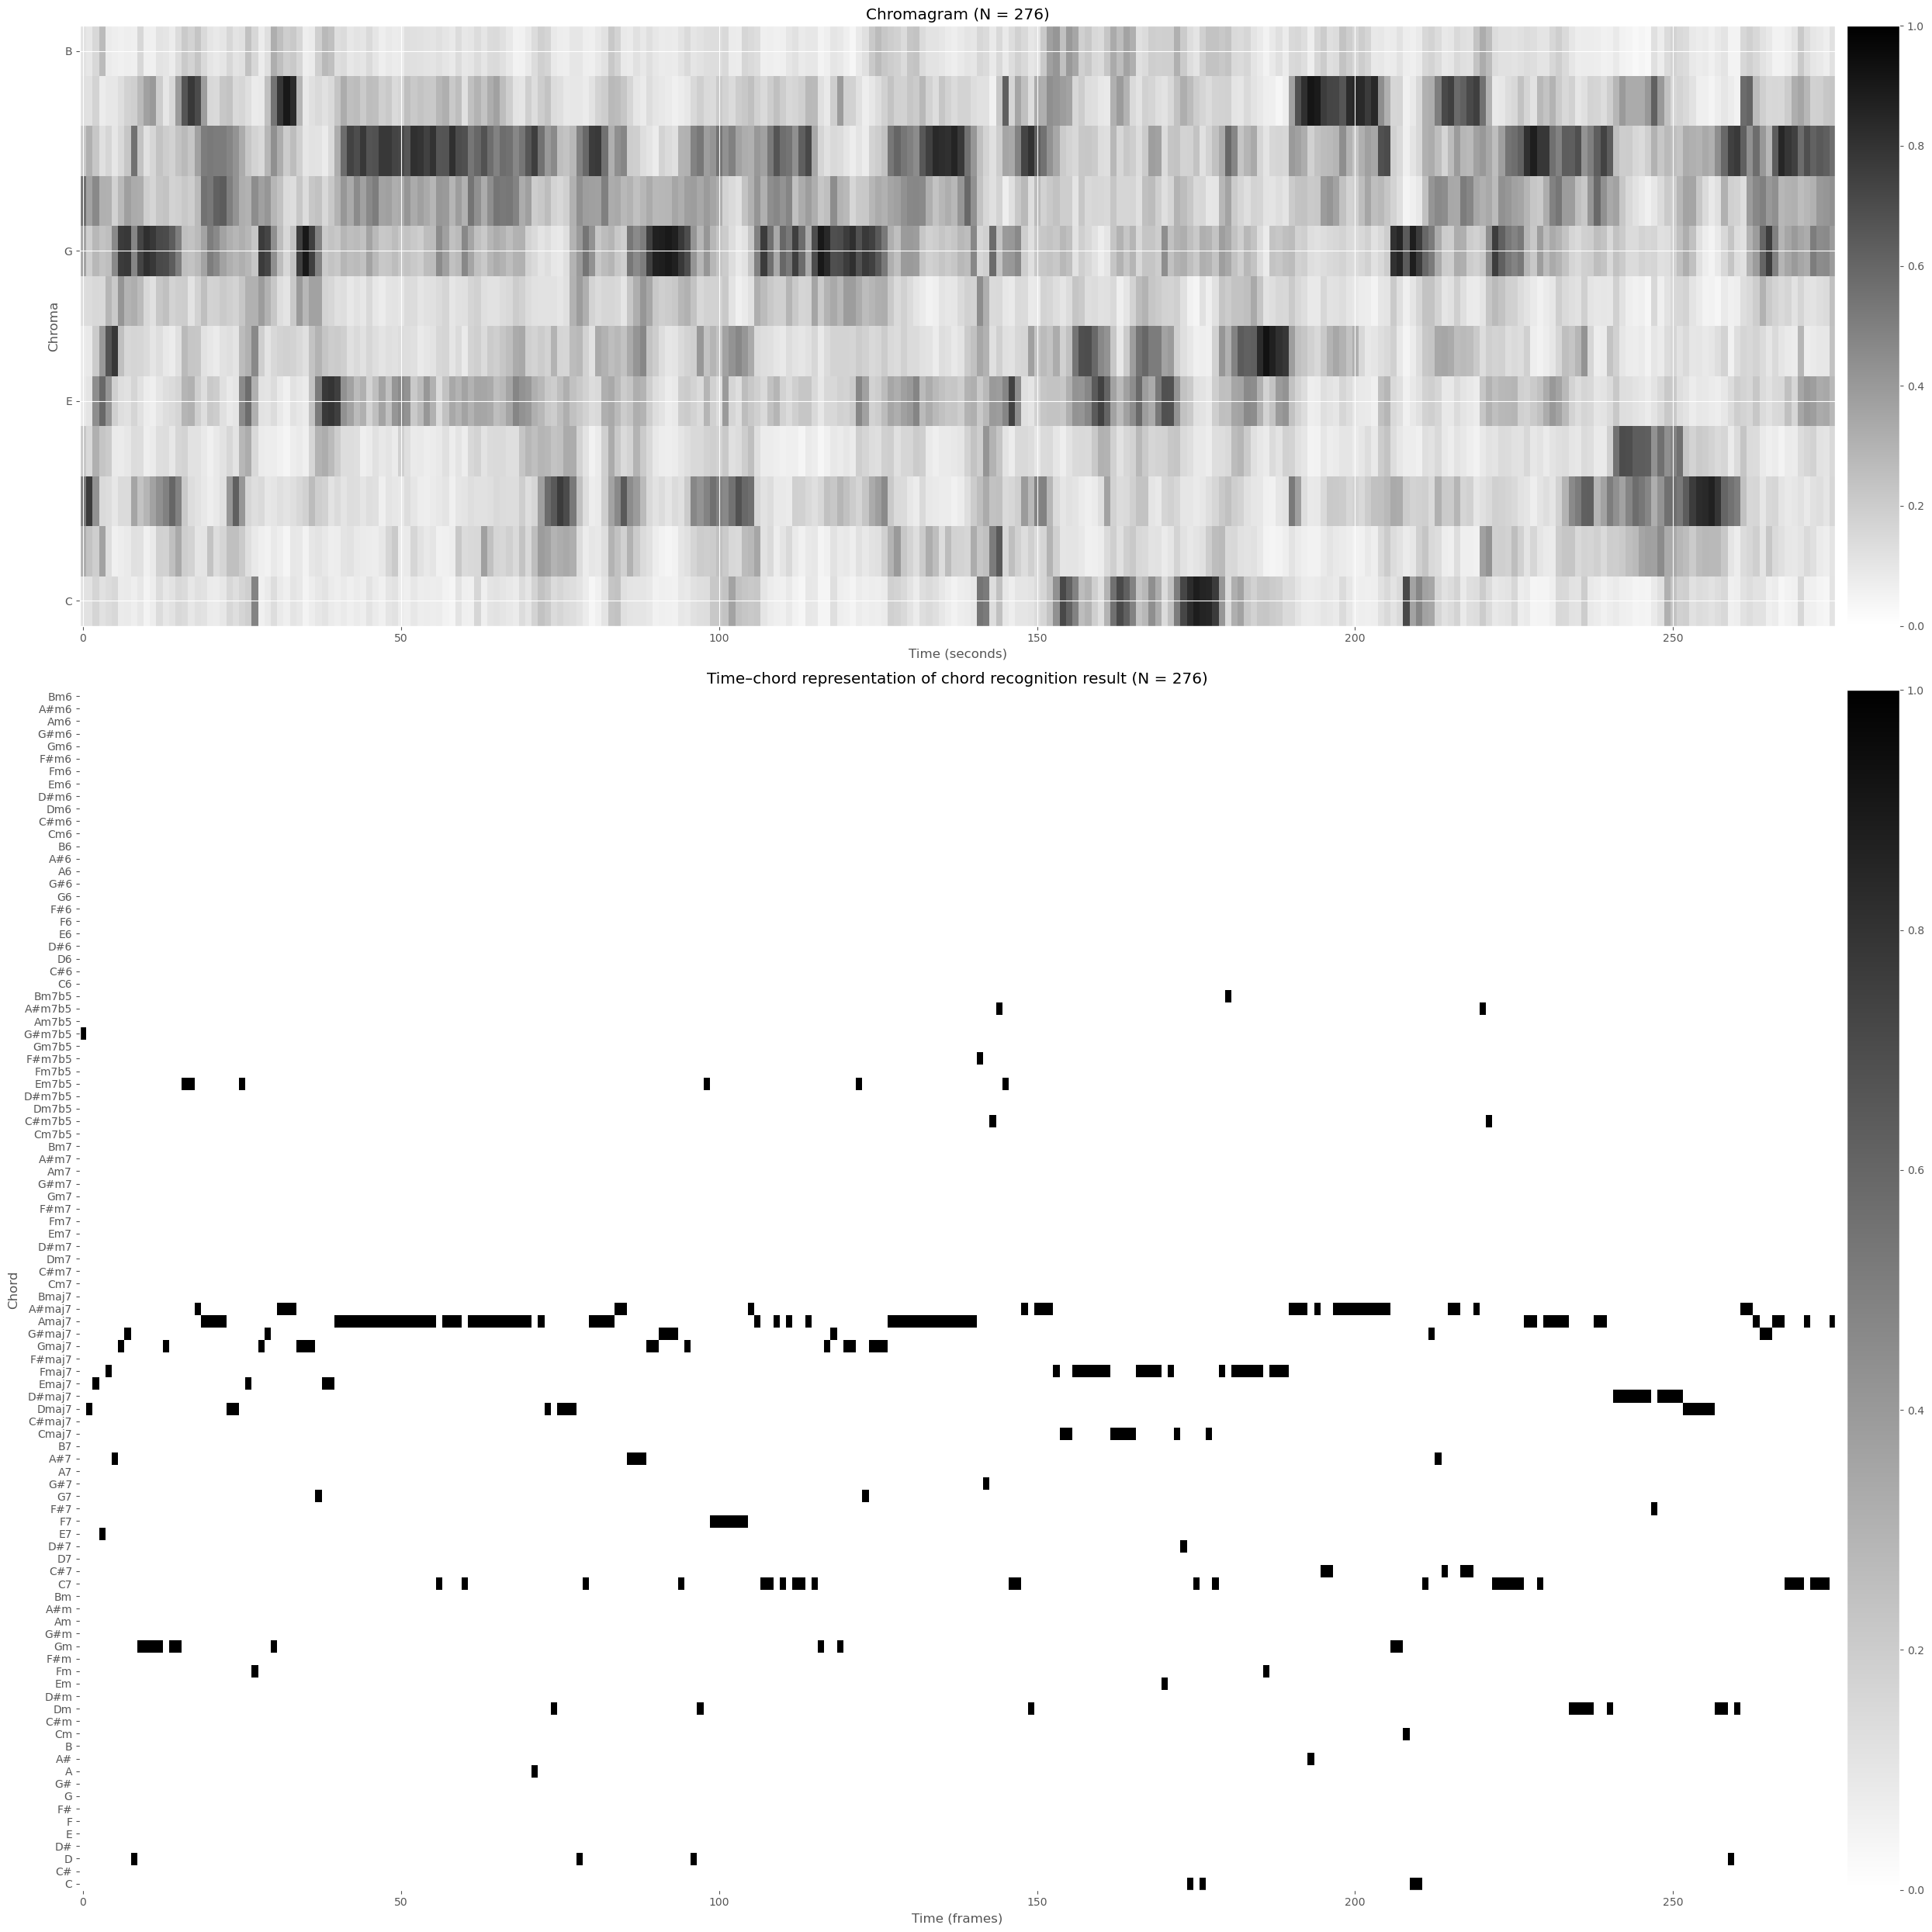

In [13]:
# Reconocimiento de acordes a partir del cromagrama X
# Se utiliza la función chord_recognition_template, que normaliza tanto X como las plantillas, calcula la similitud y asigna
# el acorde con la mayor similitud a cada frame.
chord_sim, chord_max = chord_recognition_template(X, norm_sim='max', nonchord=False)

# Generación de las etiquetas extendidas para los acordes.
# Asegúrate de que la función get_chord_labels_extended se corresponde con la versión actualizada que genera 96 etiquetas.
# Si no has renombrado la función, puedes usar la función get_chord_labels previamente definida.
chord_labels = get_chord_labels(nonchord=False)

# Visualización:
# Se crean dos subgráficas en una figura.
fig, ax = plt.subplots(2, 2, 
                       gridspec_kw={'width_ratios': [1, 0.03], 'height_ratios': [1, 2]},
                       figsize=(25, 25))

# 1) Visualización del cromagrama
title = 'Chromagram (N = %d)' % X.shape[1]
plot_chromagram(X, Fs=1, 
                         ax=[ax[0, 0], ax[0, 1]],
                         chroma_yticks=[0, 4, 7, 11], clim=[0, 1],
                         cmap='gray_r', title=title, ylabel='Chroma', colorbar=True)

# 2) Visualización del resultado del reconocimiento de acordes:
title = 'Time–chord representation of chord recognition result (N = %d)' % X.shape[1]
plot_matrix(chord_max, ax=[ax[1, 0], ax[1, 1]],
                     Fs=1, title=title, ylabel='Chord', xlabel='Time (frames)')

# Personalizar los ejes con las etiquetas generadas:
ax[1, 0].set_yticks(np.arange(len(chord_labels)))
ax[1, 0].set_yticklabels(chord_labels)
ax[1, 0].grid()

plt.tight_layout()
plt.show()



In [14]:
def convert_chord_label(ann):
    """Replace for segment-based annotation in each chord label the string ':min' by 'm'
    and convert flat chords into sharp chords using enharmonic equivalence.

    Args:
        ann (list): Segment-based annotation with chord labels,
                    where each element es [start, end, chord_label].

    Returns:
        ann_conv (list): Converted segment-based annotation with chord labels.
    """
    ann_conv = copy.deepcopy(ann)
    
    for k in range(len(ann)):
        # Reemplazo de ':min' por 'm'
        ann_conv[k][2] = ann_conv[k][2].replace(':min', 'm')
        
        # Se puede ampliar para otros tipos, si fuera necesario, por ejemplo:
        # ann_conv[k][2] = ann_conv[k][2].replace(':min7', 'm7')
        # ann_conv[k][2] = ann_conv[k][2].replace(':maj7', 'maj7')
        # ann_conv[k][2] = ann_conv[k][2].replace(':m7b5', 'm7b5')
        # ... (añadir según el formato de las anotaciones)

        # Conversión de acordes en bemol a sostenido
        ann_conv[k][2] = ann_conv[k][2].replace('Db', 'C#')
        ann_conv[k][2] = ann_conv[k][2].replace('Eb', 'D#')
        ann_conv[k][2] = ann_conv[k][2].replace('Gb', 'F#')
        ann_conv[k][2] = ann_conv[k][2].replace('Ab', 'G#')
        ann_conv[k][2] = ann_conv[k][2].replace('Bb', 'A#')
    return ann_conv


In [15]:
def convert_sequence_ann(seq, Fs=1):
    """Convert label sequence into segment-based annotation.

    Args:
        seq (list): Label sequence (por ejemplo, acorde asignado a cada frame).
        Fs (scalar): Feature rate (default = 1). Indica cuántos frames hay por unidad de tiempo.

    Returns:
        ann (list): Segment-based annotation, donde cada elemento es
                    [start_time, end_time, label].
    """
    ann = []
    for m in range(len(seq)):
        # Se asigna a cada frame un segmento centrado en el índice m. 
        # Esto genera un segmento que inicia en (m-0.5)/Fs y termina en (m+0.5)/Fs.
        ann.append([(m - 0.5) / Fs, (m + 0.5) / Fs, seq[m]])
    return ann


Con este conjunto de funciones se consigue un flujo completo para:

Leer y procesar anotaciones estructurales en formato CSV.

Convertir las anotaciones a una representación interna en la que se ajusten los tiempos según la frecuencia de muestreo y se normalice la notación de las etiquetas (por ejemplo, eliminando ambigüedades en la notación).

Generar un esquema de colores automáticamente para cada etiqueta, facilitando la visualización y comparación de la estructura musical.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm

def read_csv(fn, header=True, add_label=False):
    """Read a CSV file in table format and creates a pd.DataFrame from it, with observations in the
    rows and variables in the columns.
    
    Args:
        fn (str): Filename
        header (bool): Boolean (Default value = True)
        add_label (bool): Add column with constant value of `add_label` (Default value = False)
    
    Returns:
        df (pd.DataFrame): Pandas DataFrame
    """
    df = pd.read_csv(fn, sep=';', keep_default_na=False, header=0 if header else None)
    if add_label:
        assert 'label' not in df.columns, 'Label column must not exist if `add_label` is True'
        df = df.assign(label=[add_label] * len(df.index))
    return df

def convert_structure_annotation(ann, Fs=1, remove_digits=False, index=False):
    """Convert structure annotations
    
    Notebook: C4/C4S1_MusicStructureGeneral.ipynb
    
    Args:
        ann (list): Structure annotions
        Fs (scalar): Sampling rate (Default value = 1)
        remove_digits (bool): Remove digits from labels (Default value = False)
        index (bool): Round to nearest integer (Default value = False)
    
    Returns:
        ann_converted (list): Converted annotation
    """
    ann_converted = []
    for r in ann:
        s = r[0] * Fs
        t = r[1] * Fs
        if index:
            s = int(np.round(s))
            t = int(np.round(t))
        if remove_digits:
            label = ''.join([i for i in r[2] if not i.isdigit()])
        else:
            label = r[2]
        ann_converted = ann_converted + [[s, t, label]]
    return ann_converted

def get_color_for_labels(labels, cmap_name='tab20'):
    """
    Asigna un color distinto a cada etiqueta utilizando un mapa de colores categórico.
    
    Args:
        labels (list): Lista de etiquetas (por ejemplo, ['C', 'Cm', 'C7', ...]).
        cmap_name (str): Nombre del colormap a utilizar (default 'tab20').
    
    Returns:
        color_dict (dict): Diccionario que asigna a cada etiqueta un color (en formato RGBA).
    """
    # Obtener el colormap con la cantidad exacta de colores necesarios:
    cmap = cm.get_cmap(cmap_name, len(labels))
    color_dict = {label: cmap(i) for i, label in enumerate(labels)}
    return color_dict

def read_structure_annotation(fn_ann, fn_ann_color='', Fs=1, remove_digits=False, index=False):
    """Read and convert structure annotation and colors
    
    Notebook: C4/C4S1_MusicStructureGeneral.ipynb
    
    Args:
        fn_ann (str): Path and filename for structure annotions
        fn_ann_color (str): Filename used to identify colors (Default value = '')
        Fs (scalar): Sampling rate (Default value = 1)
        remove_digits (bool): Remove digits from labels (Default value = False)
        index (bool): Round to nearest integer (Default value = False)
    
    Returns:
        ann (list): Annotations
        color_ann (dict): Color scheme
    """
    df = read_csv(fn_ann)
    ann = [(start, end, label) for i, (start, end, label) in df.iterrows()]
    ann = convert_structure_annotation(ann, Fs=Fs, remove_digits=remove_digits, index=index)
    color_ann = {}
    
    # Generar el diccionario de colores de forma automática.
    # Se extraen las etiquetas únicas de la anotación convertida (el tercer elemento de cada segmento)
    unique_labels = sorted(list(set([entry[2] for entry in ann])))
    color_ann = get_color_for_labels(unique_labels, cmap_name='tab20')
    
    return ann, color_ann


In [18]:
def convert_ann_to_seq_label(ann):
    """Convert structure annotation with integer time positions (given in indices)
    into label sequence

    Notebook: C4/C4S5_Evaluation.ipynb

    Args:
        ann (list): Annotation (list ``[[s, t, 'label'], ...]``, with ``s``, ``t`` being integers)

    Returns:
        X (list): Sequencs of labels
    """
    X = []
    for seg in ann:
        K = seg[1] - seg[0]
        for k in range(K):
            X.append(seg[2])
    return X

def convert_chord_ann_matrix(fn_ann, chord_labels, Fs=1, N=None, last=False):
    """Convert segment-based chord annotation into various formats

    Notebook: C5/C5S2_ChordRec_Eval.ipynb

    Args:
        fn_ann (str): Filename of segment-based chord annotation
        chord_labels (list): List of chord labels
        Fs (scalar): Feature rate (Default value = 1)
        N (int): Number of frames to be generated (by cutting or extending).
            Only enforced for ann_matrix, ann_frame, ann_seg_frame (Default value = None)
        last (bool): If 'True' uses for extension last chord label, otherwise uses nonchord label 'N'
            (Default value = False)

    Returns:
        ann_matrix (np.ndarray): Encoding of label sequence in form of a binary time-chord representation
        ann_frame (list): Label sequence (specified on the frame level)
        ann_seg_frame (list): Encoding of label sequence as segment-based annotation (given in indices)
        ann_seg_ind (list): Segment-based annotation with segments (given in indices)
        ann_seg_sec (list): Segment-based annotation with segments (given in seconds)
    """
    ann_seg_sec, _ = read_structure_annotation(fn_ann)
    ann_seg_sec = convert_chord_label(ann_seg_sec)
    ann_seg_ind, _ = read_structure_annotation(fn_ann, Fs=Fs, index=True)
    ann_seg_ind = convert_chord_label(ann_seg_ind)

    ann_frame = convert_ann_to_seq_label(ann_seg_ind)
    if N is None:
        N = len(ann_frame)
    if N < len(ann_frame):
        ann_frame = ann_frame[:N]
    if N > len(ann_frame):
        if last:
            pad_symbol = ann_frame[-1]
        else:
            pad_symbol = 'N'
        ann_frame = ann_frame + [pad_symbol] * (N-len(ann_frame))
    ann_seg_frame = convert_sequence_ann(ann_frame, Fs=1)

    num_chords = len(chord_labels)
    ann_matrix = np.zeros((num_chords, N))
    for n in range(N):
        label = ann_frame[n]
        # Generates a one-entry only for labels that are contained in "chord_labels"
        if label in chord_labels:
            label_index = chord_labels.index(label)
            ann_matrix[label_index, n] = 1
    return ann_matrix, ann_frame, ann_seg_frame, ann_seg_ind, ann_seg_sec

# Conversión de Anotaciones de Acordes y Asignación de Colores

En este bloque se realiza lo siguiente:

1. **Definición de la Ruta al Archivo de Anotaciones**  
   Se establece la ruta del archivo CSV que contiene la anotación segmentada de acordes.  
   _Nota: Ajusta la ruta (fn_ann) según la ubicación y nombre de tu archivo de anotaciones._

2. **Generación de la Lista Extendida de Etiquetas de Acordes**  
   Se llama a la función `get_chord_labels(nonchord=False)` para obtener la lista de etiquetas correspondientes a 
   nuestro sistema de reconocimiento. Dado que hemos ampliado el conjunto de acordes para incluir triadas, 
   séptimas, acordes disminuidos, acordes con sexta, etc., esta función generará, por ejemplo, 96 etiquetas (sin incluir 
   la etiqueta "N") que son coherentes con las plantillas utilizadas.

3. **Determinación del Número de Frames**  
   Se extrae el número de frames del cromagrama `X` previamente calculado, utilizando `N_X = X.shape[1]`.

4. **Conversión de la Anotación Segmentada a Diversos Formatos**  
   Se invoca la función `convert_chord_ann_matrix(fn_ann, chord_labels, Fs=Fs_X, N=N_X, last=True)` para transformar la anotación:
    - **ann_matrix**: una matriz binaria de dimensiones (num_chords, N), donde cada columna representa un frame y cada fila un acorde.
    - **ann_frame**: la secuencia de etiquetas a nivel de frame.
    - **ann_seg_frame**: la anotación segmentada a partir de la secuencia de etiquetas (cada frame se convierte en un segmento).
    - **ann_seg_ind**: anotación segmentada con tiempos expresados en índices.
    - **ann_seg_sec**: anotación segmentada con tiempos en segundos.
   
   El parámetro `last=True` indica que, si es necesario extender la secuencia para alcanzar N frames, se utiliza el último acorde de la secuencia; de lo contrario, se usaría la etiqueta "N" (nonchord).

5. **Asignación de Esquema de Colores**  
   Se define un diccionario `color_ann` que asigna manualmente un color (en formato RGBA) a algunas etiquetas comunes, 
   como 'C', 'G', 'Am', 'F' y 'N'.  
   _Nota: Dado que el sistema ahora utiliza un mayor número de acordes, este esquema de colores es solo un ejemplo. 
   Para una asignación automática se puede utilizar la función `get_color_for_labels` sobre las etiquetas únicas de la anotación._



In [19]:
# Annotations
fn_ann = os.path.join('/home/cepatinog/ethnomusic/amplab-musicology-andina/if_0172_chords_converted.csv')
# chord_labels = libfmp.c5.get_chord_labels(ext_minor='m', nonchord=False)
chord_labels = get_chord_labels(nonchord=False)
N_X = X.shape[1]
ann_matrix, ann_frame, ann_seg_frame, ann_seg_ind, ann_seg_sec = convert_chord_ann_matrix(fn_ann, chord_labels, 
                                                                           Fs=Fs_X, N=N_X, last=True)

/tmp/ipykernel_150954/4283211439.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(labels))
/tmp/ipykernel_150954/4283211439.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(labels))


In [20]:
import libfmp.b

In [22]:
ann, color_ann = read_structure_annotation(fn_ann, Fs=Fs_X, remove_digits=False, index=True)


/tmp/ipykernel_150954/4283211439.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(labels))


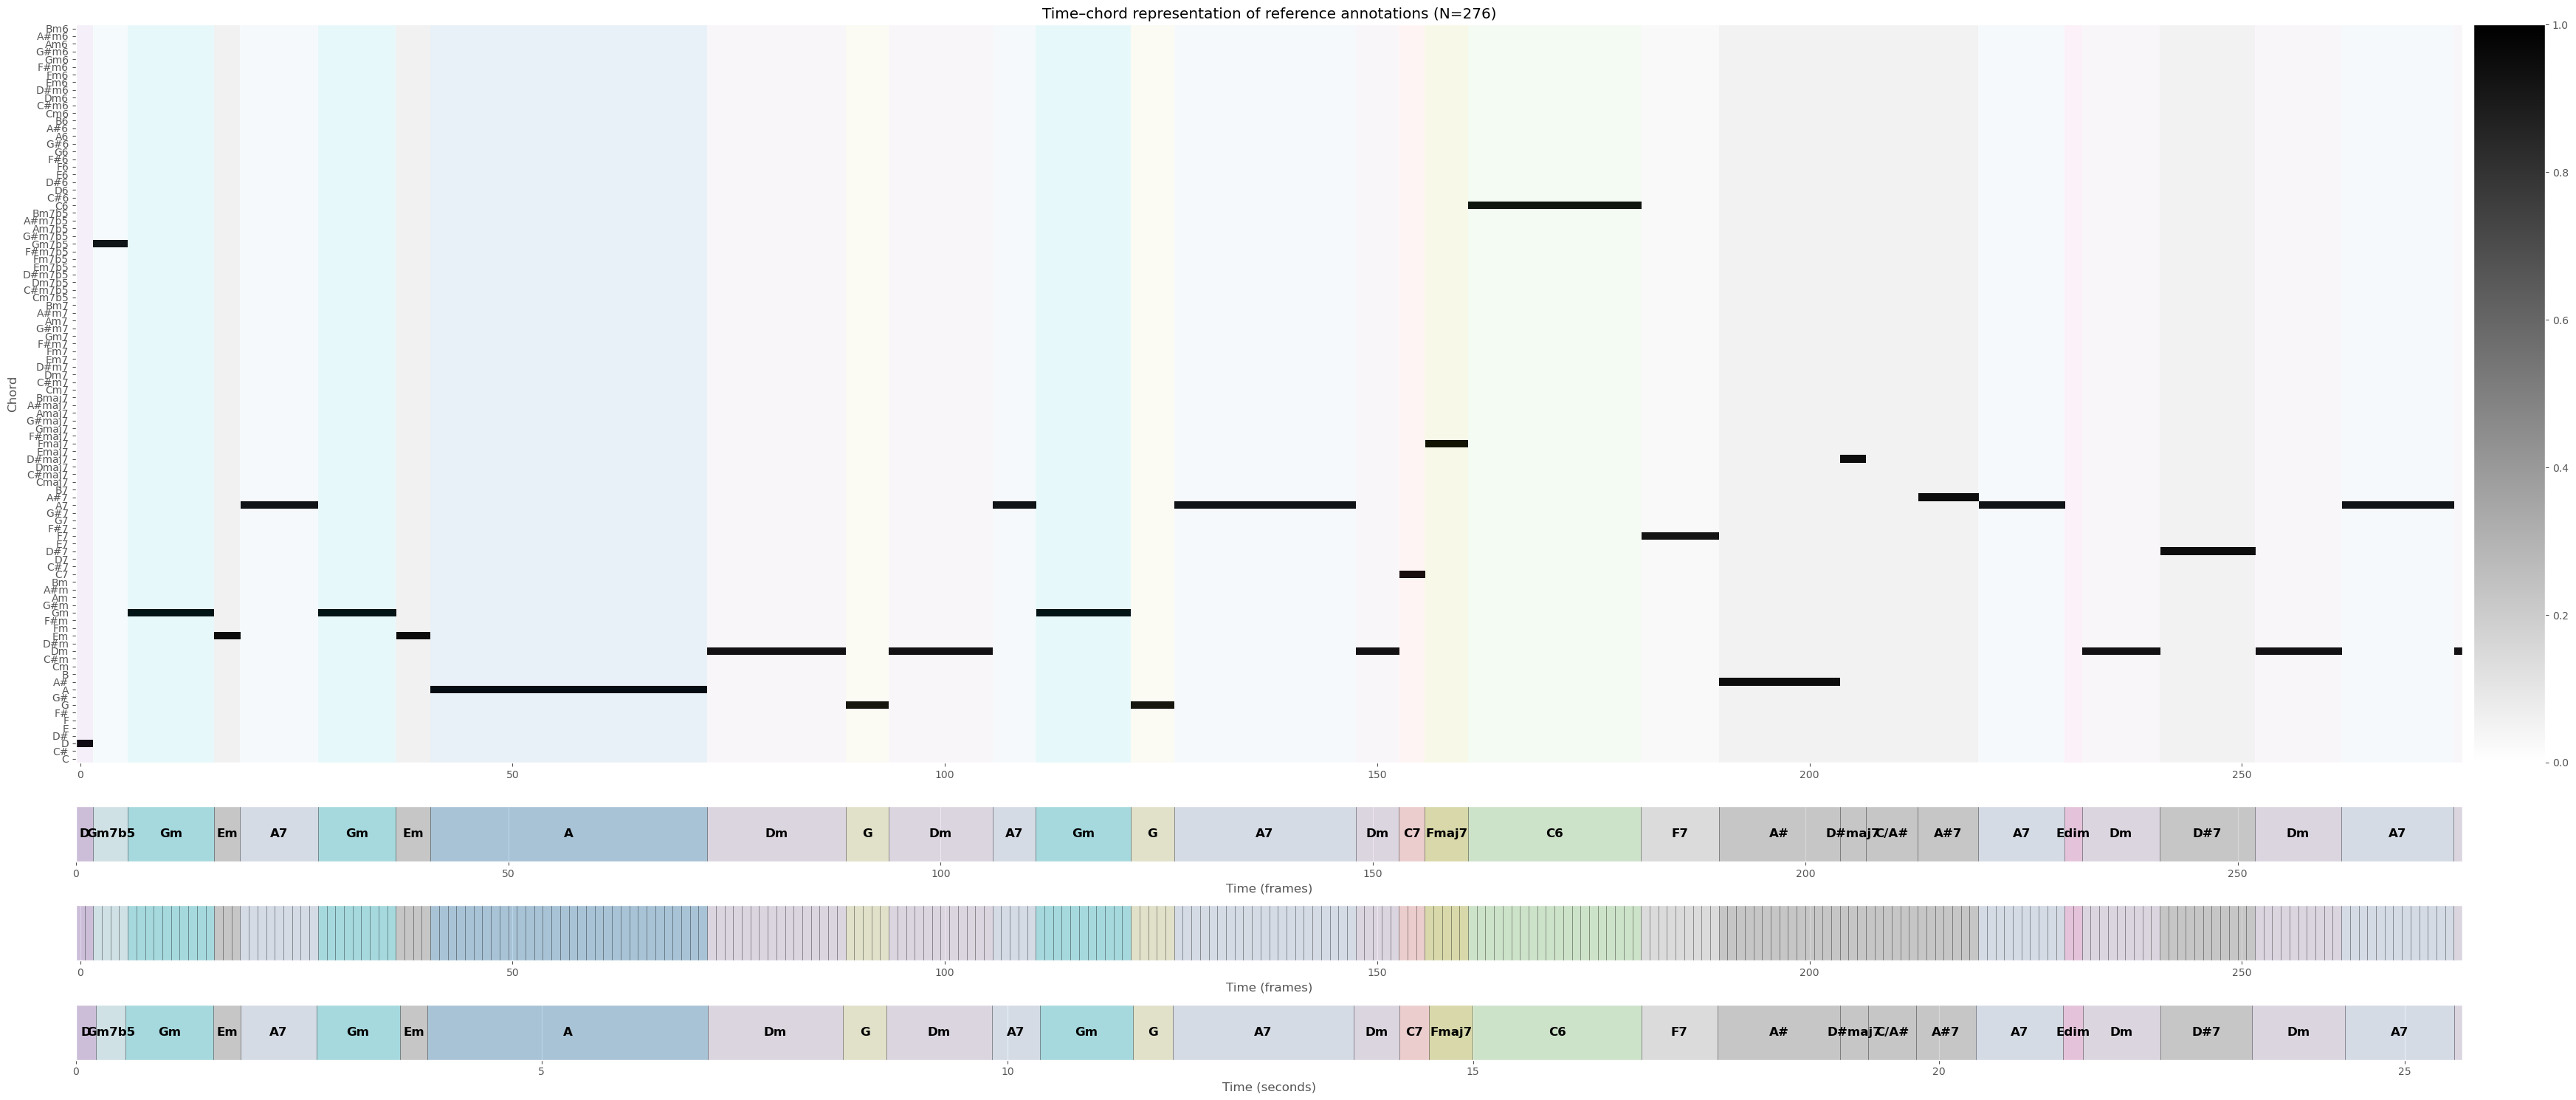

In [24]:
# Plot
cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [4, 0.3, 0.3, 0.3]}, 
                       figsize=(35, 15))

libfmp.b.plot_matrix(ann_matrix, ax=[ax[0, 0], ax[0, 1]], Fs=1, 
                     title='Time–chord representation of reference annotations (N=%d)' % ann_matrix.shape[1],
                     ylabel='Chord', xlabel='')
ax[0, 0].set_yticks(np.arange( len(chord_labels) ))
ax[0, 0].set_yticklabels(chord_labels)
libfmp.b.plot_segments_overlay(ann_seg_frame, ax=ax[0, 0], 
                               print_labels=False, colors=color_ann, alpha=0.1)
ax[0, 0].grid()
libfmp.b.plot_segments(ann_seg_ind, ax=ax[1, 0], time_label='Time (frames)', time_max=N_X,
                       colors=color_ann,  alpha=0.3)
ax[1, 1].axis('off')
libfmp.b.plot_segments(ann_seg_frame, ax=ax[2, 0], time_label='Time (frames)', 
                       colors=color_ann,  alpha=0.3, print_labels=False)
ax[2, 1].axis('off')
libfmp.b.plot_segments(ann_seg_sec, ax=ax[3, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[3, 1].axis('off')
plt.tight_layout()

# Función compute_eval_measures

Esta función se utiliza para evaluar el rendimiento de un sistema de reconocimiento de acordes (o de cualquier sistema de clasificación) a nivel de frames mediante la comparación de la salida estimada (I_est) con una referencia (I_ref). Ambas entradas se esperan en formato de matriz binaria, donde cada fila representa una etiqueta de acorde y cada columna un frame. En cada elemento se asume que:
- Un valor 1 indica que en ese frame se ha asignado el acorde correspondiente.
- Un valor 0 indica que ese acorde no está presente en ese frame.

La función calcula las siguientes métricas:

1. **True Positives (TP)**:  
   Se calcula como la suma de los elementos donde tanto en I_ref como en I_est hay un 1, es decir, se emplea:
   
       TP = sum( logical_and(I_ref, I_est) )
       
   Esto cuenta cuántos frames se han clasificado correctamente.

2. **False Positives (FP)**:  
   Se determinan como la suma de los elementos en I_est que son mayores que cero menos los TP:
   
       FP = sum( I_est > 0 ) - TP
       
   Es decir, son los frames en los que el sistema ha asignado un acorde pero la referencia no lo tenía (o el acorde es incorrecto).

3. **False Negatives (FN)**:  
   Se calculan como la suma de los elementos en I_ref que son mayores que cero menos los TP:
   
       FN = sum( I_ref > 0 ) - TP
       
   Representa los frames en los que la referencia tenía un acorde, pero el sistema no lo detectó (o falló en asignarlo correctamente).

4. **Precisión (P)**:  
   La precisión se define como la proporción de verdaderos positivos entre el total de predicciones positivas:
   
       P = TP / (TP + FP)
       
   Indica qué tan fiables son las predicciones positivas del sistema.

5. **Recall (R)**:  
   La exhaustividad se define como la proporción de verdaderos positivos entre todos los casos positivos reales:
   
       R = TP / (TP + FN)
       
   Mide la capacidad del sistema para recuperar los casos positivos.

6. **F-measure (F)**:  
   La F-medida es la media armónica de la precisión y el recall, y se define como:
   
       F = 2 * P * R / (P + R)
       
   Es una medida combinada que equilibra ambas métricas.

Antes de realizar los cálculos, la función verifica que las dimensiones de I_ref e I_est sean iguales, ya que ambas matrices deben coincidir frame a frame.

En caso de que TP (verdaderos positivos) sea mayor que cero, se calculan las métricas P, R y F. Si TP es 0, se mantiene P = R = F = 0 para evitar divisiones por cero.

Finalmente, la función retorna P, R, F junto con los números TP, FP y FN para tener un análisis más completo.

Esta función es muy útil para evaluar el desempeño de un sistema de reconocimiento de acordes, ya que ofrece métricas globales que indican la proporción de frames correctamente etiquetados, así como los errores por falsos positivos y falsos negativos.


In [25]:
def compute_eval_measures(I_ref, I_est):
    """Compute evaluation measures including precision, recall, and F-measure

    Notebook: C5/C5S2_ChordRec_Eval.ipynb

    Args:
        I_ref (np.ndarray): Reference set of items
        I_est (np.ndarray): Set of estimated items

    Returns:
        P (float): Precision
        R (float): Recall
        F (float): F-measure
        num_TP (int): Number of true positives
        num_FN (int): Number of false negatives
        num_FP (int): Number of false positives
    """
    assert I_ref.shape == I_est.shape, "Dimension of input matrices must agree"
    TP = np.sum(np.logical_and(I_ref, I_est))
    FP = np.sum(I_est > 0, axis=None) - TP
    FN = np.sum(I_ref > 0, axis=None) - TP
    P = 0
    R = 0
    F = 0
    if TP > 0:
        P = TP / (TP + FP)
        R = TP / (TP + FN)
        F = 2 * P * R / (P + R)
    return P, R, F, TP, FP, FN

# Visualización Evaluativa de Acordes (plot_matrix_chord_eval)

La función `plot_matrix_chord_eval` se encarga de crear una visualización evaluativa sobre la diferencia entre la anotación de referencia y la estimación del sistema, en una cuadrícula tiempo–acorde. Este gráfico muestra de forma codificada con colores la presencia de:
  
- **True Negatives (TN)**: Casos correctos en que el acorde no está presente (valor 0).
- **False Positives (FP)**: Casos en que el sistema detecta un acorde cuando la referencia no lo tiene (valor 1).
- **False Negatives (FN)**: Casos en que la referencia tiene un acorde, pero el sistema no lo detecta (valor 2).
- **True Positives (TP)**: Casos correctos en que ambos, sistema y referencia, coinciden en la detección (valor 3).

## Funcionamiento de la función

1. **Preparación de la Figura y Ejes**  
   Si no se proporcionan ejes (`ax is None`), la función crea una figura con un único subplot. Se asegura de trabajar con `ax` como lista, ya que más adelante se utiliza `ax[0]` para mostrar el mapa y `ax[1]` (si está disponible) para la barra de colores.

2. **Cálculo de TP, FP y FN (Operaciones Element-wise)**  
   - `I_TP` se obtiene haciendo una operación lógica *element-wise* (`np.logical_and`) entre la matriz de referencia `I_ref` y la de estimación `I_est`, y luego se convierte en una matriz de enteros. Esto marca en cada celda 1 cuando ambos tienen 1, y 0 en caso contrario.
   - `I_FP` se calcula restando `I_TP` de `I_est`, es decir, se obtienen los casos donde el sistema asigna un acorde que la referencia no tiene.
   - `I_FN` se calcula restando `I_TP` de `I_ref`, identificando los casos en que la referencia marca un acorde y la estimación falla.

3. **Construcción de la Matriz de Visualización (`I_vis`)**  
   Cada elemento de la matriz evaluativa se codifica con un número:
   - 0: TN (ninguna detección)
   - 1: FP
   - 2: FN
   - 3: TP  
   Se define `I_vis` como:  
     `I_vis = 3 * I_TP + 2 * I_FN + 1 * I_FP`  
   De esta manera, cada celda adquiere un valor que será mapeado a un color específico.

4. **Definición del Colormap y Normas**  
   Se utiliza un colormap listado (`ListedColormap`) con cuatro colores:
   - Blanco para 0 (TN).
   - Un rojo claro ([1, 0.3, 0.3]) para FP.
   - Un rojo intermedio ([1, 0.7, 0.7]) para FN.
   - Negro para 3 (TP).  
   Además, se definen los límites (`eval_bounds`) y se normaliza la imagen con `BoundaryNorm` para mapear los valores a las clases adecuadas. Los ticks de la barra se establecen en [0, 1, 2, 3] y se etiquetan como TN, FP, FN, TP.

5. **Cálculo de la Extensión y Mapeo de Ejes**  
   Se calcula el rango de tiempo (en el eje X) utilizando `np.arange` y se ajusta el `extent` de la imagen para que los ejes queden centrados en los valores correctos.
  
6. **Generación del Plot**  
   Se utiliza `ax[0].imshow` para mostrar `I_vis` con los parámetros de colormap, extensión y normalización.  
   Si existen dos ejes en `ax`, se utiliza el segundo para la barra de color; de lo contrario se agrega una barra de color a `ax[0]`.  
  
7. **Configuración Final de Ejes**  
   Se establecen las etiquetas del eje X y Y, y el título.  
   Si se proporciona `chord_labels`, se configuran los ticks del eje Y para representar cada acorde en la vertical.  
   Finalmente, se activa la cuadricula si se solicitó.

La función retorna la figura, los ejes y el objeto de imagen generado.

Este gráfico es especialmente útil para visualizar, de manera comparativa, los errores de clasificación (FP, FN) y los aciertos (TP) en la asignación de acordes a lo largo del tiempo.


In [31]:
def plot_matrix_chord_eval(I_ref, I_est, Fs=1, xlabel='Time (seconds)', ylabel='Chord',
                           title='', chord_labels=None, ax=None, grid=True, figsize=(9, 3.5)):
    """Plots TP-, FP-, and FN-items in a color-coded form in a time–chord grid.

    Args:
        I_ref (np.ndarray): Matriz de referencia (binary matrix).
        I_est (np.ndarray): Matriz de estimación (binary matrix).
        Fs (scalar): Tasa de frames (Default: 1).
        xlabel (str): Etiqueta del eje X (por defecto 'Time (seconds)').
        ylabel (str): Etiqueta del eje Y (por defecto 'Chord').
        title (str): Título de la figura.
        chord_labels (list): Lista de etiquetas de acordes a usar en el eje Y.
        ax (list or None): Array de ejes sobre el cual plotear. Si es None, se crea la figura.
        grid (bool): Si es True, se activa la cuadricula.
        figsize (tuple): Tamaño de la figura (si no se especifican ejes).

    Returns:
        fig: Figura matplotlib (o None si se pasaron ejes).
        ax: Ejes utilizados.
        im: Objeto del plot de imagen.
    """
    # Si no se proveen ejes, se crea una figura con un subplot.
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax = [ax]
    
    # Calcular matrices element-wise para TP, FP y FN.
    # Convertir I_ref e I_est a matrices binarias (asegurándose que sean del mismo tamaño).
    I_TP = np.logical_and(I_ref, I_est).astype(np.int32)   # Verdaderos positivos: donde ambas tienen 1.
    I_FP = I_est - I_TP                                     # Falsos positivos: donde I_est es 1 pero I_ref es 0.
    I_FN = I_ref - I_TP                                     # Falsos negativos: donde I_ref es 1 pero I_est es 0.
    
    # Crear la matriz de visualización: se asigna un valor numérico a cada tipo:
    #   3 para TP, 2 para FN, 1 para FP y 0 para TN.
    I_vis = 3 * I_TP + 2 * I_FN + 1 * I_FP

    # Definir un colormap específico que asigna:
    # - 0 (TN) → blanco [1,1,1]
    # - 1 (FP) → rojo pálido [1, 0.3, 0.3]
    # - 2 (FN) → rojo más pálido [1, 0.7, 0.7]
    # - 3 (TP) → negro [0, 0, 0]
    eval_cmap = colors.ListedColormap([[1, 1, 1], [1, 0.3, 0.3], [1, 0.7, 0.7], [0, 0, 0]])
    eval_bounds = np.array([0, 1, 2, 3, 4]) - 0.5
    eval_norm = colors.BoundaryNorm(eval_bounds, 4)
    eval_ticks = [0, 1, 2, 3]

    # Definir coordenadas temporales y de acorde para el plot.
    T_coef = np.arange(I_vis.shape[1]) / Fs
    F_coef = np.arange(I_vis.shape[0])
    x_ext1 = (T_coef[1] - T_coef[0]) / 2
    x_ext2 = (T_coef[-1] - T_coef[-2]) / 2
    y_ext1 = (F_coef[1] - F_coef[0]) / 2
    y_ext2 = (F_coef[-1] - F_coef[-2]) / 2
    extent = [T_coef[0] - x_ext1, T_coef[-1] + x_ext2, F_coef[0] - y_ext1, F_coef[-1] + y_ext2]

    # Mostrar la imagen de I_vis utilizando imshow.
    im = ax[0].imshow(I_vis, origin='lower', aspect='auto', cmap=eval_cmap,
                      norm=eval_norm, extent=extent, interpolation='nearest')
    
    # Mostrar la barra de colores en un segundo eje si se provee; de lo contrario, se agrega a ax[0].
    if len(ax) == 2:
        cbar = plt.colorbar(im, cax=ax[1], cmap=eval_cmap, norm=eval_norm,
                             boundaries=eval_bounds, ticks=eval_ticks)
    elif len(ax) == 1:
        plt.sca(ax[0])
        cbar = plt.colorbar(im, cmap=eval_cmap, norm=eval_norm,
                             boundaries=eval_bounds, ticks=eval_ticks)
    cbar.ax.set_yticklabels(['TN', 'FP', 'FN', 'TP'])

    # Configurar etiquetas y título del eje.
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)
    
    # Si se proporciona una lista de etiquetas para los acordes, se establecen en el eje Y.
    if chord_labels is not None:
        ax[0].set_yticks(np.arange(len(chord_labels)))
        ax[0].set_yticklabels(chord_labels)
        
    # Activar cuadricula si se solicita.
    if grid:
        ax[0].grid()
    
    return fig, ax, im


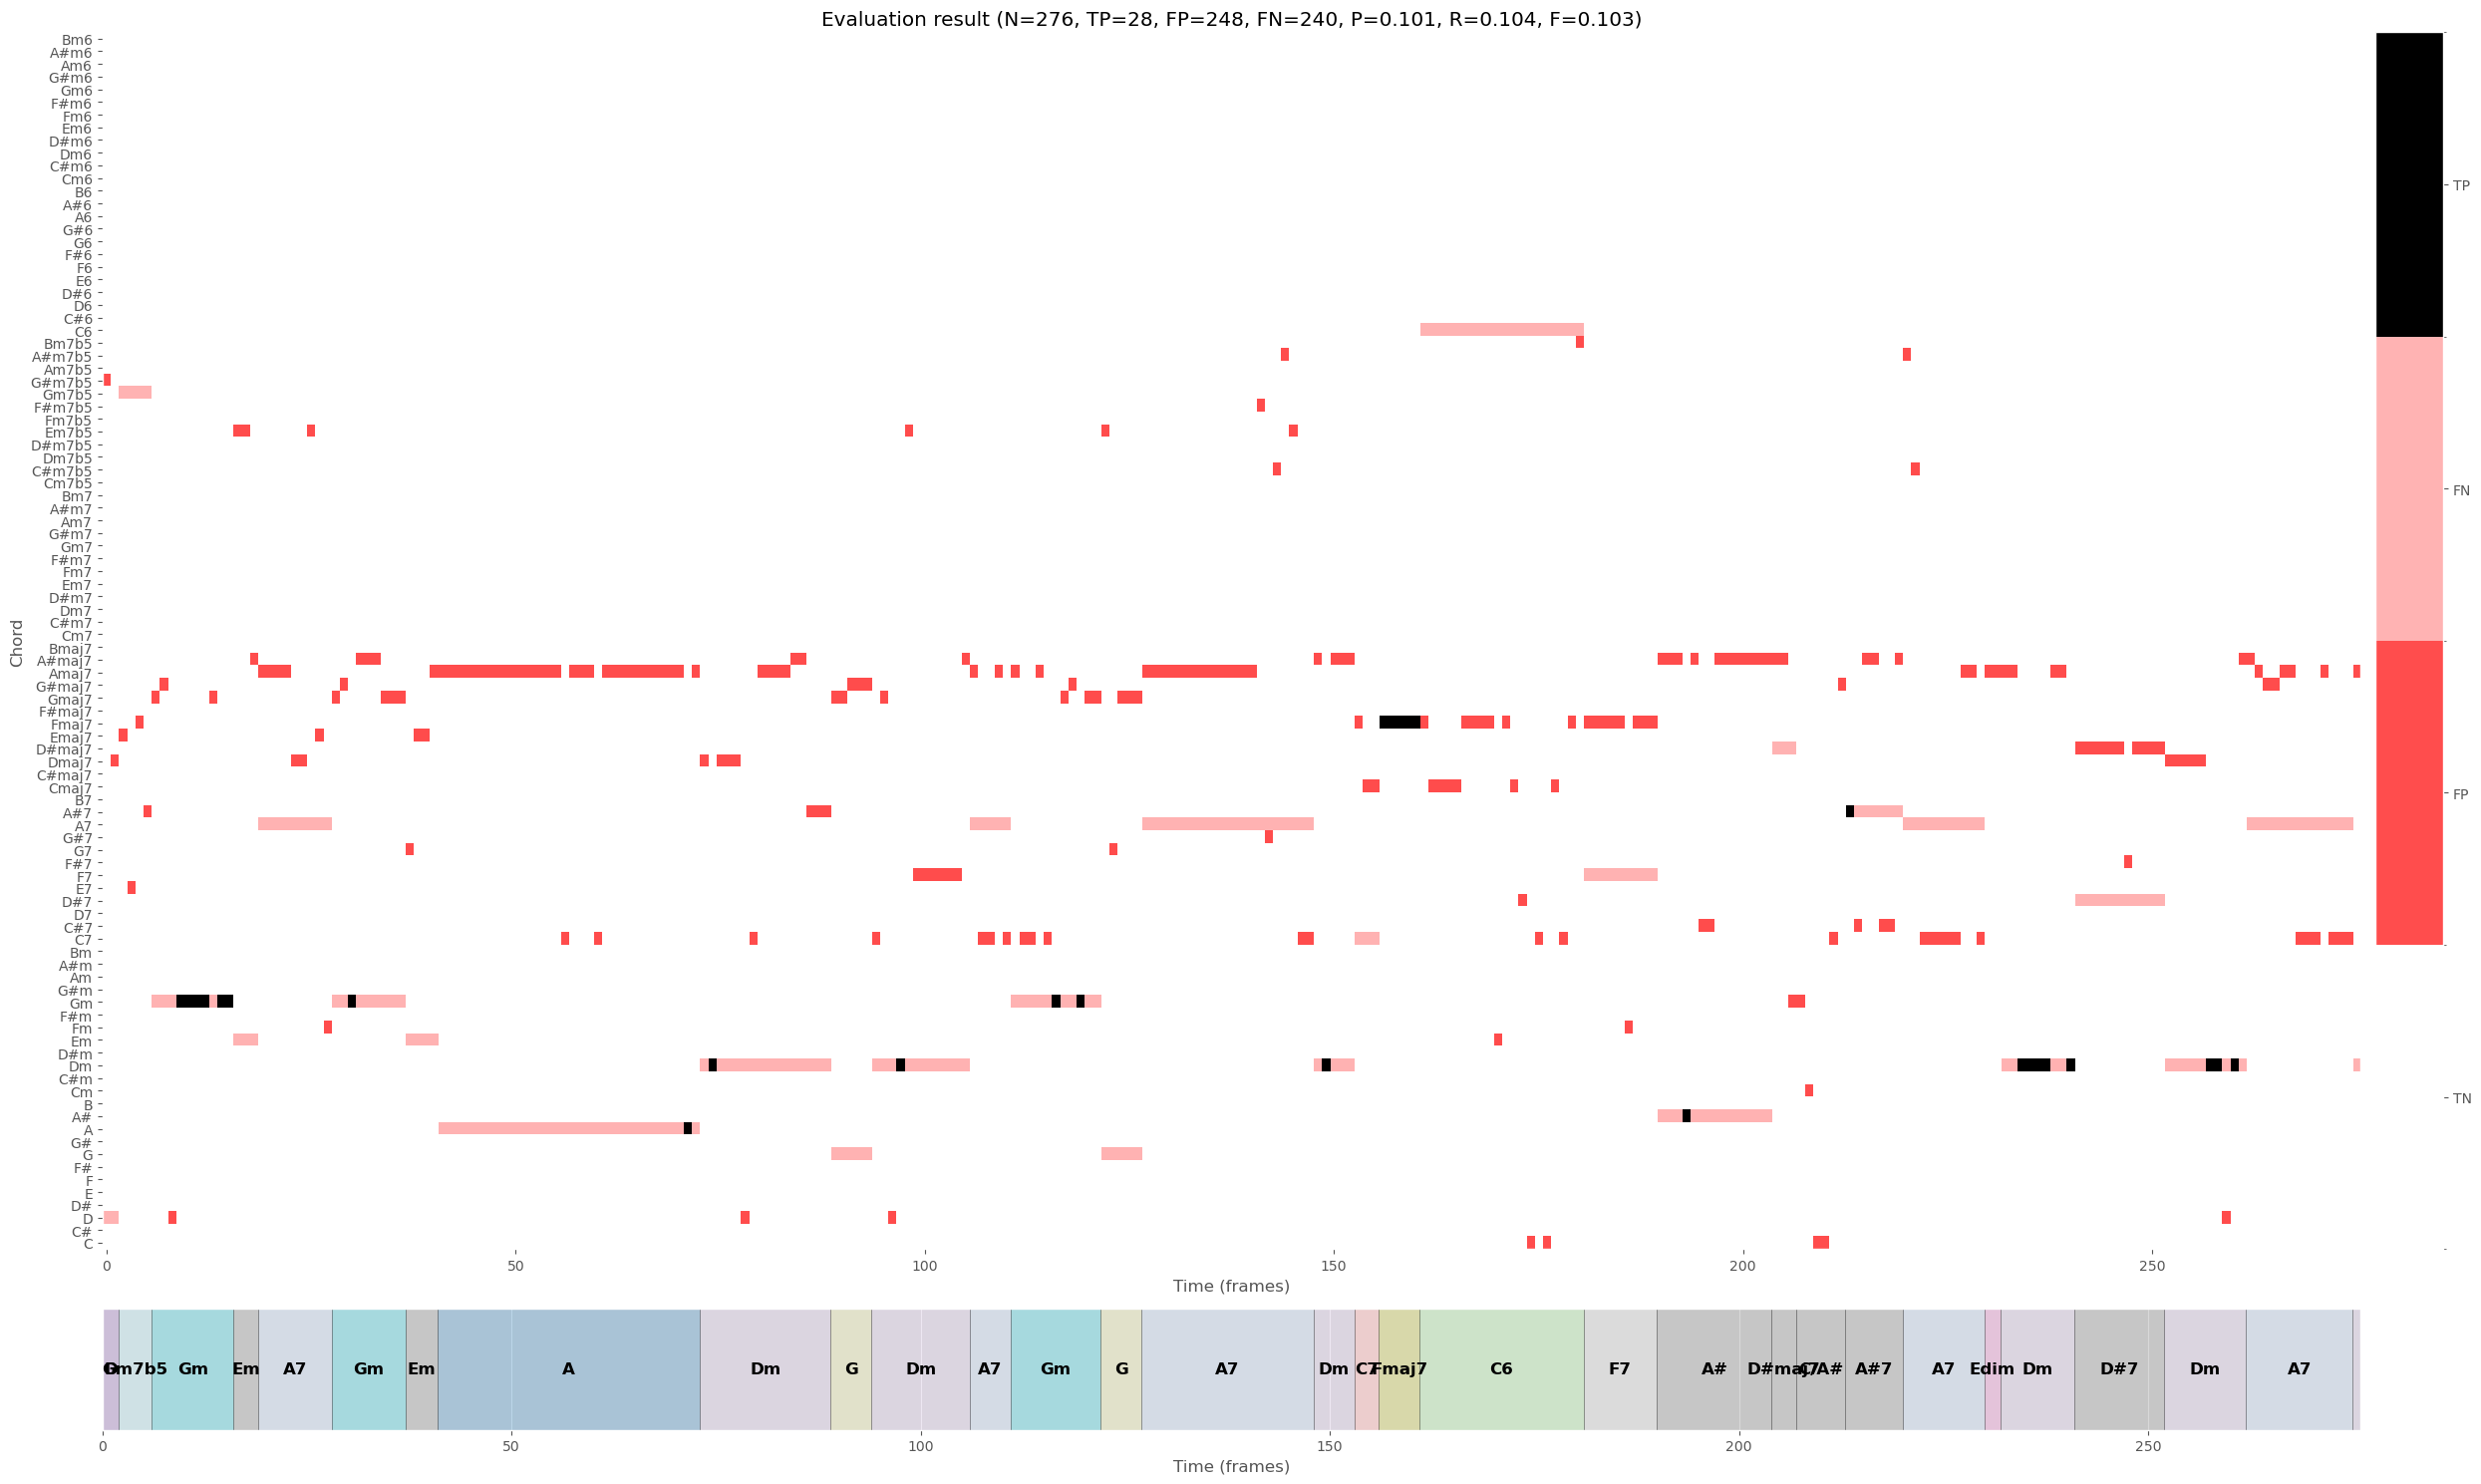

In [32]:
P, R, F, TP, FP, FN = compute_eval_measures(ann_matrix, chord_max)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [2, 0.2]}, figsize=(25, 15))

title = 'Evaluation result (N=%d, TP=%d, FP=%d, FN=%d, P=%.3f, R=%.3f, F=%.3f)' % (N_X, TP, FP, FN, P,R,F)
plot_matrix_chord_eval(ann_matrix, chord_max, ax=[ax[0, 0], ax[0, 1]], Fs=1, 
                       title=title, ylabel='Chord', xlabel='Time (frames)', chord_labels=chord_labels)

libfmp.b.plot_segments(ann_seg_ind, ax=ax[1, 0], time_label='Time (frames)', time_max=N_X,
                       colors=color_ann,  alpha=0.3)
ax[1, 1].axis('off')
plt.tight_layout()
plt.show()